In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

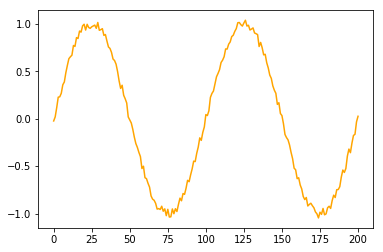

In [3]:
T = 100
f = toy_problem(T)
plt.plot(f, color='orange')
plt.show()

In [4]:
length_of_sequences = 2 * T  # 全時系列の長さ
maxlen = 25  # １つの時系列の長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [5]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [6]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

# TensorFlowによる実装

In [7]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    state = initial_state
    outputs = []  # 過去の隠れ層の出力を保存
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c  # 線形活性
    return y

In [8]:
def loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step

In [9]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [10]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

In [11]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [12]:
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

In [13]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size
early_stopping = EarlyStopping(patience=10, verbose=1)


for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                n_batch: batch_size
                })
            
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                n_batch: N_validation
            })   
            
            # 値を記録しておく
            print('epoch: ', epoch,
                 ' validation loss: ', val_loss)
            
            if early_stopping.validate(val_loss):
                break

epoch:  0  validation loss:  0.340072
epoch:  0  validation loss:  0.334691
epoch:  0  validation loss:  0.329219
epoch:  0  validation loss:  0.323475
epoch:  0  validation loss:  0.317499
epoch:  0  validation loss:  0.311225
epoch:  0  validation loss:  0.304574
epoch:  0  validation loss:  0.297658
epoch:  0  validation loss:  0.290399
epoch:  0  validation loss:  0.282786
epoch:  0  validation loss:  0.274837
epoch:  0  validation loss:  0.266575
epoch:  0  validation loss:  0.258059
epoch:  0  validation loss:  0.249342
epoch:  0  validation loss:  0.240613
epoch:  1  validation loss:  0.232025
epoch:  1  validation loss:  0.223734
epoch:  1  validation loss:  0.215971
epoch:  1  validation loss:  0.208889
epoch:  1  validation loss:  0.202644
epoch:  1  validation loss:  0.197288
epoch:  1  validation loss:  0.192319
epoch:  1  validation loss:  0.188369
epoch:  1  validation loss:  0.184893
epoch:  1  validation loss:  0.180367
epoch:  1  validation loss:  0.176309
epoch:  1  v

epoch:  48  validation loss:  0.00184226
epoch:  48  validation loss:  0.00193595
epoch:  48  validation loss:  0.00201192
epoch:  48  validation loss:  0.00215155
epoch:  48  validation loss:  0.00225223
epoch:  49  validation loss:  0.00215821
epoch:  49  validation loss:  0.00212942
epoch:  49  validation loss:  0.00217179
epoch:  49  validation loss:  0.00230356
epoch:  49  validation loss:  0.0025339
early stopping
epoch:  50  validation loss:  0.00214011
early stopping
epoch:  51  validation loss:  0.00180128
early stopping
epoch:  52  validation loss:  0.00178584
early stopping
epoch:  53  validation loss:  0.00168675
epoch:  53  validation loss:  0.00160926
epoch:  53  validation loss:  0.00150623
epoch:  53  validation loss:  0.00151785
epoch:  53  validation loss:  0.00161855
epoch:  53  validation loss:  0.00178285
epoch:  53  validation loss:  0.00210322
epoch:  53  validation loss:  0.0024988
epoch:  53  validation loss:  0.00227568
epoch:  53  validation loss:  0.00186315

epoch:  208  validation loss:  0.00187831
early stopping
epoch:  209  validation loss:  0.00191796
early stopping
epoch:  210  validation loss:  0.00194998
early stopping
epoch:  211  validation loss:  0.00198693
early stopping
epoch:  212  validation loss:  0.00189446
early stopping
epoch:  213  validation loss:  0.00191411
early stopping
epoch:  214  validation loss:  0.00199294
early stopping
epoch:  215  validation loss:  0.0019998
early stopping
epoch:  216  validation loss:  0.00178911
early stopping
epoch:  217  validation loss:  0.00160292
early stopping
epoch:  218  validation loss:  0.00159528
early stopping
epoch:  219  validation loss:  0.00162803
early stopping
epoch:  220  validation loss:  0.00162101
early stopping
epoch:  221  validation loss:  0.00151597
early stopping
epoch:  222  validation loss:  0.00150112
early stopping
epoch:  223  validation loss:  0.0015116
early stopping
epoch:  224  validation loss:  0.00154503
early stopping
epoch:  225  validation loss:  0.

epoch:  404  validation loss:  0.00201371
early stopping
epoch:  405  validation loss:  0.00218539
early stopping
epoch:  406  validation loss:  0.00258673
early stopping
epoch:  407  validation loss:  0.00301271
early stopping
epoch:  408  validation loss:  0.00300907
early stopping
epoch:  409  validation loss:  0.00302073
early stopping
epoch:  410  validation loss:  0.00277364
early stopping
epoch:  411  validation loss:  0.00243285
early stopping
epoch:  412  validation loss:  0.00163198
early stopping
epoch:  413  validation loss:  0.00133322
early stopping
epoch:  414  validation loss:  0.00132837
early stopping
epoch:  415  validation loss:  0.00135078
early stopping
epoch:  416  validation loss:  0.00136589
early stopping
epoch:  417  validation loss:  0.00139185
early stopping
epoch:  418  validation loss:  0.00138153
early stopping
epoch:  419  validation loss:  0.00137003
early stopping
epoch:  420  validation loss:  0.00136968
early stopping
epoch:  421  validation loss:  

In [14]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [15]:
for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
    (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

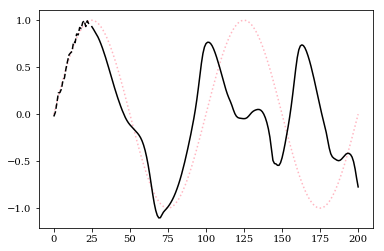

In [16]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Kerasによる実装

In [17]:
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [18]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

In [19]:
model = Sequential()
model.add(SimpleRNN(n_hidden, init=weight_variable,
                   input_shape=(maxlen, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('linear'))

/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(20, input_shape=(25, 1), kernel_initializer=<function ...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shimazu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer=<function ...)`
  after removing the cwd from sys.path.


In [20]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [22]:
epochs = 500
batch_size = 10

model.fit(X_train, Y_train, batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_validation, Y_validation),
         callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 0s 2ms/step - loss: 0.4969 - val_loss: 0.3050
Epoch 2/500
158/158 [==============================] - 0s 411us/step - loss: 0.4254 - val_loss: 0.2641
Epoch 3/500
158/158 [==============================] - 0s 363us/step - loss: 0.3353 - val_loss: 0.2035
Epoch 4/500
158/158 [==============================] - 0s 365us/step - loss: 0.2101 - val_loss: 0.1194
Epoch 5/500
158/158 [==============================] - 0s 360us/step - loss: 0.0833 - val_loss: 0.0588
Epoch 6/500
158/158 [==============================] - 0s 355us/step - loss: 0.0386 - val_loss: 0.0356
Epoch 7/500
158/158 [==============================] - 0s 360us/step - loss: 0.0330 - val_loss: 0.0333
Epoch 8/500
158/158 [==============================] - 0s 358us/step - loss: 0.0301 - val_loss: 0.0396
Epoch 9/500
158/158 [==============================] - 0s 403us/step - loss: 0.0265 - val_loss: 0.0191
Epoch 10/500
158/158 [========

In [23]:
truncate = 25
Z = X[:1]

original = [f[i] for i in range(25)]
predicted = [None for i in range(25)]

for i in range(200 - 25 + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
    (z_.reshape(25, n_in)[1:], y_),
    axis=0).reshape(1, 25, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

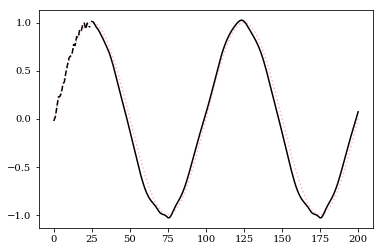

In [24]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()